# First steps with bayesloop

*bayesloop* models feature a two-level hierarchical structure: the low-level, observation model filters out measurement noise and provides the parameters, that one is interested in (volatility of stock prices, diffusion coefficient of particles, directional persistence of migrating cancer cells, rate of randomly occurring events, ...). The observation model is, in most cases, given by a simple and well-known stochastic process: price changes are Gaussian-distributed, turning angles of moving cells follow a von-Mises distribution and the number of rare events within a given interval of time is Poisson-distributed. The aim of the observation model is to describe the measured data on a short time scale, while the parameters may change on longer time scales. The high-level, transition model describes *how* the parameters of the observation model change over time, i.e. whether there are abrupt parameter jumps or gradual variations. The transition model may itself depend on so-called hyper-parameters, for example the likelihood of parameter jumps, the magnitude of gradual parameter variations or the slope of a deterministic linear trend. The following tutorials show how to use the *bayesloop* module to infer both time-varying parameter values of the observation model as well as the hyper-parameter values of the transition model and compare different hypotheses about the parameter dynamics by approximating the model evidence, i.e. the probability of the measured data, given the observation model and transition model.

The first section of the tutorial introduces the main class of the module, `Study`, which enables fits of time-varying parameter models with fixed hyper-parameter values and the optimization of such hyper-parameters based on the model evidence. We provide a detailed description of how to import data, set the observation model and transition model, and perform the model fit. Finally, a plotting function to display the results is discussed briefly. This tutorial therefore provides the basis for later tutorials that discuss the extended classes `HyperStudy`, `ChangepointStudy` and `OnlineStudy`. 

## Study class
To start a new data study/analysis, create a new instance of the `Study` class:

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt # plotting
import seaborn as sns           # nicer plots
sns.set_style('whitegrid')      # plot styling

import bayesloop as bl

S = bl.Study()

+ Created new study.


This object is central to an analysis conducted with *bayesloop*. It stores the data and further provides the methods to perform probabilistic inference on the models defined within the class, as described below.

## Data import
In this first study, we use a simple, yet instructive example of heterogeneous time series, the annual number of coal mining accidents in the UK from 1851 to 1962. The data is imported as a NumPy array, together with corresponding timestamps. Note that setting timestamps is optional (if none are provided, timestamps are set to an integer sequence: 0, 1, 2,...).

In [2]:
import numpy as np

data = np.array([5, 4, 1, 0, 4, 3, 4, 0, 6, 3, 3, 4, 0, 2, 6, 3, 3, 5, 4, 5, 3, 1, 4,
                 4, 1, 5, 5, 3, 4, 2, 5, 2, 2, 3, 4, 2, 1, 3, 2, 2, 1, 1, 1, 1, 3, 0,
                 0, 1, 0, 1, 1, 0, 0, 3, 1, 0, 3, 2, 2, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0,
                 0, 2, 1, 0, 0, 0, 1, 1, 0, 2, 3, 3, 1, 1, 2, 1, 1, 1, 1, 2, 3, 3, 0,
                 0, 0, 1, 4, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0])

S.load(data, timestamps=np.arange(1852, 1962))

+ Successfully imported array.


Note that this particular data set is also hard-coded into the `Study` class, for convenient testing:

In [3]:
S.loadExampleData()

+ Successfully imported example data.


In case you have multiple observations for each time step, you may also provide the data in the form `np.array([[x1,y1,z1], [x2,y2,z2], ..., [xn,yn,zn]])`. Missing data points should be included as `np.nan`.

## Observation model
The first step to create a probabilistic model to explain the data is to define the **observation model**, or **likelihood**. The observation model states the probability (density) of a data point at time $t$, given the parameter values at time $t$ and possibly past data points. It therefore resembles the low-level model, in contrast to the transition model which describes how the parameters of the observation model change over time.

As coal mining disasters fortunately are rare events, we may model the number of accidents per year by a [Poisson](https://en.wikipedia.org/wiki/Poisson_distribution) distribution. In *bayesloop*, this is done as follows:

In [4]:
L = bl.observationModels.Poisson('accident_rate', bl.oint(0, 6, 1000))
S.set(L)

+ Observation model: Poisson. Parameter(s): ['accident_rate']


We first define the observation model and provide two arguments: A name for the only parameter of the model, the `'accident_rate'`. We further have to provide discrete values for this parameter, as *bayesloop* computes all probability distributions on grids. As the Poisson distribution expects its parameter to be greater than zero, we choose an *open* interval between 0 and 6 with 1000 equally spaced values in between, by using the function `bl.oint()`. For closed intervals, one can also use `bl.cint()`, which acts exactly like the function `linspace` from NumPy. To avoid singularities in the probability values of the observation model, it is however recommended to use `bl.oint()` in most cases. Finally, we assign the defined observation model to our study instance with the method `set()`.

As the parameter boundaries depend on the data at hand, *bayesloop* will estimate appropriate parameter values, if one does not provide them:

In [5]:
L = bl.observationModels.Poisson('accident_rate')
S.set(L)

+ Estimated parameter interval for "accident_rate": [0.00749250749251, 7.49250749251] (1000 values).
+ Observation model: Poisson. Parameter(s): ['accident_rate']


Note that you can also use the following short form to define observation models: `L = bl.om.Poisson()`. All currently implemented observation models can be looked up in the [API Docs](../api.html) or directly in `observationModels.py`. *bayesloop* further supports all probability distributions that are included in the [scipy.stats](http://docs.scipy.org/doc/scipy/reference/stats.html) as well as the [sympy.stats](http://docs.sympy.org/dev/modules/stats.html) module. See [this tutorial](customobservationmodels.html) for instructions on how to build custom observation models from arbitrary distributions.

In this example, the observation model only features a single parameter. If we wanted to model the annual number of accidents with a Gaussian distribution instead, we have to supply two parameter names (`mean` and `std`) and corresponding values:
```
L = bl.om.Gaussian('mean', bl.cint(0, 6, 200), 'std', bl.oint(0, 2, 200))
S.set(L)
```
Again, if we are not sure about parameter boundaries, we may assign `None` to one or all parameters, and *bayesloop* will estimate them:
```
L = bl.om.Gaussian('mean', None, 'std', bl.oint(0, 2, 200))
S.set(L)
```
The order has to remain `Name, Value, Name, Value, ...`, which is why we cannot simply omit the values and have to write `None` instead.

## Transition model
As the dynamics of many real-world systems are the result of a multitude of underlying processes that act on different spatial and time scales, common statistical models with static parameters often miss important aspects of the systems' dynamics (see e.g. this [article](http://www.nature.com/articles/ncomms8516)). *bayesloop* therefore calls for a second model, the **transition model**, which describes the temporal changes of the model parameters.

In this example, we assume that the accident rate itself may change gradually over time and choose a Gaussian random walk with the standard deviation $\sigma=0.2$ as transition model. As for the observation model, we supply a unique name for hyper-parameter $\sigma$ (named `sigma`) that describes the standard deviation of the parameter fluctuations and therefore the magnitude of changes. Again, we have to assign values for `sigma`, but only choose a single fixed value of 0.2, instead of a whole set of values. This single value can be optimized, by maximizing the model evidence, see [here](hyperparameteroptimization.html). To analyze and compare a set of different values, one may use an instance of a `HyperStudy` that is described in detail [here](hyperstudy.html). in this first example, we simply take the value of 0.2 as given. As the observation model may contain several parameters, we further have specify the parameter `accident_rate` as the target of this transition model.

In [6]:
T = bl.transitionModels.GaussianRandomWalk('sigma', 0.2, target='accident_rate')
S.set(T)

+ Transition model: Gaussian random walk. Hyper-Parameter(s): ['sigma']


Note that you can also use the following short form to define transition models: `T = bl.tm.GaussianRandomWalk()`. All currently implemented transition models can be looked up in the [API Docs](../api.html) or directly in  `transitionModels.py`.

## Model fit

At this point, the hierarchical time series model for the coal mining data set is properly defined and we may continue to perform the model fit. *bayesloop* employs a forward-backward algorithm that is based on [Hidden Markov models](http://www.cs.sjsu.edu/~stamp/RUA/HMM.pdf). It basically breaks down the high-dimensional inference problem of all time steps into many low-dimensional ones for each individual time step. The inference algorithm is implemented by the `fit` method:

In [7]:
S.fit()

+ Started new fit:
    + Formatted data.
    + Set prior (function): jeffreys. Values have been re-normalized.

    + Finished forward pass.
    + Log10-evidence: -74.63801

    + Finished backward pass.
    + Computed mean parameter values.


By default, `fit` computes the so-called *smoothing distribution* of the model parameters for each time step. This distribution states the probability (density) of the parameter value at a time step $t$, given all past and future data points. All distributions have the same shape as the parameter grid, and are stored in `S.posteriorSequence` for further analysis. Additionally, the mean values of each distribution are stored in `S.posteriorMeanValues`, as point estimates. Finally, the (natural) logarithmic value of the model evidence, the probability of the data given the chosen model, is stored in `S.logEvidence` (more details on evidence values [follow](modelselection.html)). 

To simulate an on-line analysis, where at each step in time $t$, only past data points are available, one may provide the keyword-argument `forwardOnly=True`. In this case, only the *forward*-part of the algorithm in run. The resulting parameter distributions are called *filtering distributions*.

## Plotting
To display the temporal evolution or the distribution of the model parameters at a certain time step, the `Study` class provides the method `plot`. If no time step is specified, the method displays the mean values together with the marginal distributions for one parameter of the model. The parameter to be plotted can be chosen by providing its name.

Here, we plot the original data (in red) together with the inferred disaster rate (mean value in black). The marginal parameter distribution is displayed as a blue overlay, by default with a gamma correction of $\gamma=0.5$ to enhance relative differences in the width of the distribution (this behavior can be changed by the keyword argument `gamma`):

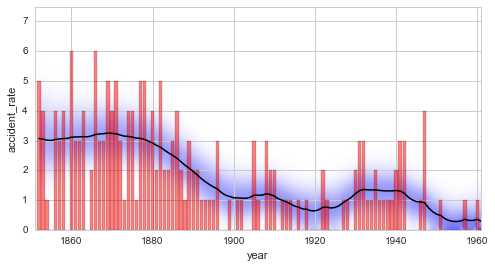

In [8]:
plt.figure(figsize=(8, 4))

# plot of raw data
plt.bar(S.rawTimestamps, S.rawData, align='center', facecolor='r', alpha=.5)

# parameter plot
S.plot('accident_rate')

plt.xlim([1851, 1961])
plt.xlabel('year');

From this first analysis, we may conclude that before 1880, an average of $\approx 3$ accidents per year were recorded. This changes significantly between 1880 and 1900, when the accident-rate drops to $\approx 1$ per year. We can also directly inspect the distribution of the accident rate at specific points in time, using the `plot` method with specified keyword argument `t`:

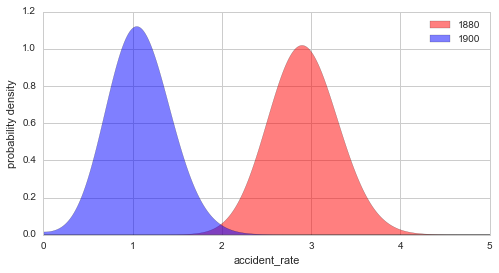

In [9]:
plt.figure(figsize=(8, 4))

S.plot('accident_rate', t=1880, facecolor='r', alpha=0.5, label='1880')
S.plot('accident_rate', t=1900, facecolor='b', alpha=0.5, label='1900')

plt.legend()
plt.xlim([0, 5]);

Without the `plot=True` argument, this method only returns the parameter values (`r1`, `r2`, as specified when setting the observation model) as well as the corresponding probability values `p1` and `p2`. Note that the returned probability values are always normalized to 1, so that we may easily evaluate the probability of certain conditions, like the probability of an accident rate < 1 in the year 1900:

We can further evaluate the probability of certain conditions, for example the probability that the accident rate was < 1 in the year 1900, using the `eval` method:

In [10]:
S.eval('accident_rate < 1', t=1900);

P(accident_rate < 1) = 0.42198256057


For further details on the evaluation of probabilities derived from a combination of inferred parameters (possibly from different `Study` instances), see [this tutorial](probabilityparser.html)

## Saving studies
As the `Study` class instance (above denoted by `S`) of a conducted analysis contains all information about the inferred parameter values, it may be convenient to store the entire instance `S` to file. This way, it can be loaded again later, for example to refine the study, create different plots or perform further analyses based on the obtained results. *bayesloop* provides two functions, `bl.save()` and `bl.load()` to store and retrieve existing studies:
```
bl.save('file.bl', S)

...

S = bl.load('file.bl)
```